<a href="https://colab.research.google.com/github/abhizc/EVA4-B2/blob/master/S7/S7Final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32


        # CONVOLUTION BLOCK 
        self.convblock232 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=32),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) 


        self.convblock264 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False, groups=64),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) 


        self.convblock2128 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False, groups=128),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) 



        # TRANSITION BLOCK 
        self.TransitionBlk = nn.Sequential(
            nn.MaxPool2d(2, 2)
        ) 
        

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False, groups=128),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        self.convblock4d = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=2, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 32



        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 


        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

        ) # output_size = 32


        self.fc = nn.Sequential(
            nn.Linear(128, 128, bias=False),
            nn.Linear(128, 10, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)

        x = self.convblock232(x)
        x = self.TransitionBlk(x)

        x = self.convblock264(x)
        x = self.TransitionBlk(x)

        x = self.convblock2128(x)
        x = self.TransitionBlk(x)

        x = self.convblock3(x)
        x1 = self.convblock4(x)
        x2 = self.convblock4d(x)

        x = x1 + x2

        x = self.gap(x)
        x = x.view(-1, 128)      
        x = self.fc(x)
        x = x.view(-1, 10)   

        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]             576
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    scheduler.step()
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=16)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.1847712993621826 Batch_id=195 Accuracy=47.18: 100%|██████████| 196/196 [00:15<00:00, 12.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0835, Accuracy: 6108/10000 (61.08%)

EPOCH: 1


Loss=0.8661082983016968 Batch_id=195 Accuracy=67.31: 100%|██████████| 196/196 [00:15<00:00, 12.86it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7965, Accuracy: 7194/10000 (71.94%)

EPOCH: 2


Loss=0.6857768893241882 Batch_id=195 Accuracy=74.45: 100%|██████████| 196/196 [00:15<00:00, 12.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6816, Accuracy: 7663/10000 (76.63%)

EPOCH: 3


Loss=0.4905109405517578 Batch_id=195 Accuracy=78.43: 100%|██████████| 196/196 [00:15<00:00, 12.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6346, Accuracy: 7785/10000 (77.85%)

EPOCH: 4


Loss=0.46107378602027893 Batch_id=195 Accuracy=81.43: 100%|██████████| 196/196 [00:15<00:00, 12.90it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5597, Accuracy: 8050/10000 (80.50%)

EPOCH: 5


Loss=0.3289059102535248 Batch_id=195 Accuracy=83.53: 100%|██████████| 196/196 [00:15<00:00, 12.95it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5409, Accuracy: 8154/10000 (81.54%)

EPOCH: 6


Loss=0.3727637827396393 Batch_id=195 Accuracy=85.44: 100%|██████████| 196/196 [00:15<00:00, 12.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 8217/10000 (82.17%)

EPOCH: 7


Loss=0.31862974166870117 Batch_id=195 Accuracy=86.98: 100%|██████████| 196/196 [00:15<00:00, 12.90it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4903, Accuracy: 8368/10000 (83.68%)

EPOCH: 8


Loss=0.29369163513183594 Batch_id=195 Accuracy=88.52: 100%|██████████| 196/196 [00:15<00:00, 12.99it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5030, Accuracy: 8369/10000 (83.69%)

EPOCH: 9


Loss=0.19199857115745544 Batch_id=195 Accuracy=89.85: 100%|██████████| 196/196 [00:15<00:00, 12.96it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5381, Accuracy: 8300/10000 (83.00%)

EPOCH: 10


Loss=0.37008222937583923 Batch_id=195 Accuracy=91.49: 100%|██████████| 196/196 [00:15<00:00, 12.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5291, Accuracy: 8426/10000 (84.26%)

EPOCH: 11


Loss=0.2665252685546875 Batch_id=195 Accuracy=92.99: 100%|██████████| 196/196 [00:15<00:00, 12.93it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5215, Accuracy: 8477/10000 (84.77%)

EPOCH: 12


Loss=0.2102256566286087 Batch_id=195 Accuracy=94.73: 100%|██████████| 196/196 [00:15<00:00, 12.88it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5279, Accuracy: 8508/10000 (85.08%)

EPOCH: 13


Loss=0.13209697604179382 Batch_id=195 Accuracy=96.04: 100%|██████████| 196/196 [00:14<00:00, 13.10it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5189, Accuracy: 8579/10000 (85.79%)

EPOCH: 14


Loss=0.03666476160287857 Batch_id=195 Accuracy=97.02: 100%|██████████| 196/196 [00:15<00:00, 12.84it/s]



Test set: Average loss: 0.5187, Accuracy: 8581/10000 (85.81%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

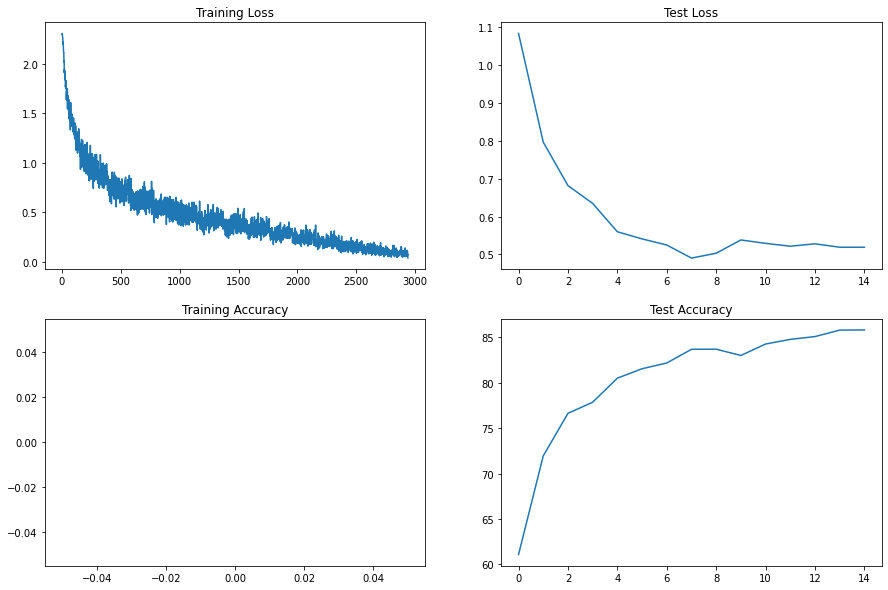

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")